In [1]:
# import packages and data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy


bace = pd.read_csv('./bace_cleaned.csv')

In [2]:
bace.head()

mol  Class         MW  \
0  O1CC[C@@H](NC(=O)[C@@H](Cc2cc3cc(ccc3nc2N)-c2c...      1  431.56979   
1  Fc1cc(cc(F)c1)C[C@H](NC(=O)[C@@H](N1CC[C@](NC(...      1  657.81073   
2  S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...      1  591.74091   
3  S1(=O)(=O)C[C@@H](Cc2cc(O[C@H](COCC)C(F)(F)F)c...      1  591.67828   
4  S1(=O)(=O)N(c2cc(cc3c2n(cc3CC)CC1)C(=O)N[C@H](...      1  629.71283   

    AlogP  HBA  HBD  RB  HeavyAtomCount  ChiralCenterCount  \
0  4.4014    3    2   5              32                  2   
1  2.6412    5    4  16              47                  6   
2  2.5499    4    3  11              42                  2   
3  3.1680    4    3  12              40                  4   
4  3.5086    3    3  11              44                  2   

   ChiralCenterCountAllPossible  ...  PEOE6 (PEOE6)  PEOE7 (PEOE7)  \
0                             2  ...      53.205711      78.640335   
1                             6  ...      73.817162      47.171600   
2                             3  ...      70.365707      47.941147   
3                             5  ...      56.657166      37.954151   
4                             3  ...      78.945702      39.361153   

   PEOE8 (PEOE8)  PEOE9 (PEOE9)  PEOE10 (PEOE10)  PEOE11 (PEOE11)  \
0      226.85541      107.43491        37.133846         0.000000   
1      365.67694      174.07675        34.923889         7.980170   
2      192.40652      255.75255        23.654478         0.230159   
3      194.35304      202.76335        36.498634         0.980913   
4      179.71288      220.46130        23.654478         0.230159   

   PEOE12 (PEOE12)  PEOE13 (PEOE13)  PEOE14 (PEOE14)  canvasUID  
0         7.980170              0.0         0.000000          1  
1        24.148668              0.0        24.663788          2  
2        15.879790              0.0        24.663788          3  
3         8.188327              0.0        26.385181          4  
4        15.879790              0.0        26.100143          5  

[5 rows x 366 columns]

We still have over 360 features, which is a lot. Let's see if there any strongly correlated features that we can combine into new, condensed features.

In [3]:
import sys
!python -m pip install fastcluster

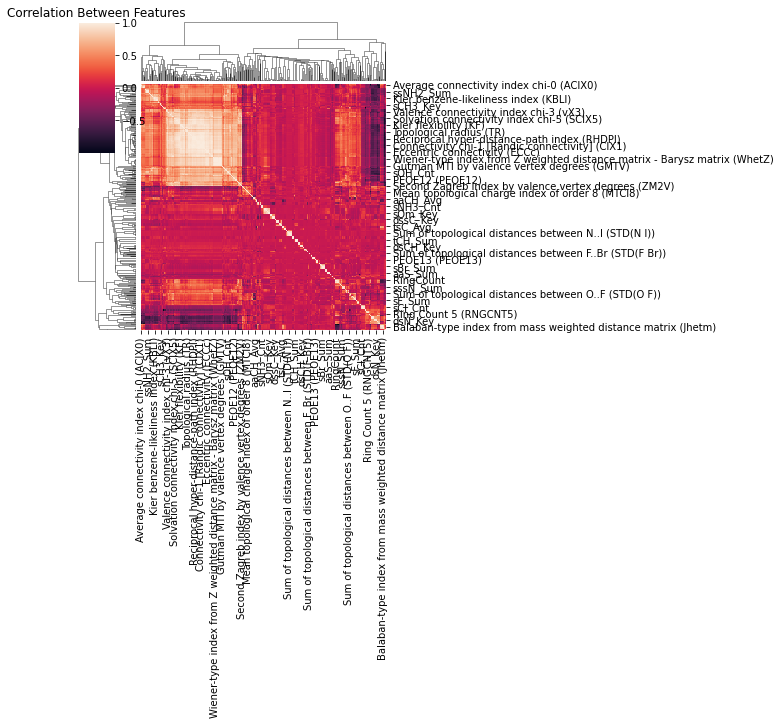

In [4]:
import fastcluster

corr_mat = bace.corr()

sns.clustermap(corr_mat)
plt.title("Correlation Between Features")

plt.show()

Somewhat predictably, the individual correlations in the above graph are impossible to discern. However, this plot is not without some value: it is clear that there are regions of highly correlated features that might be reducible. Let's plot the correlations of the features to Class to identify a subset of features with the highest correlations to class.

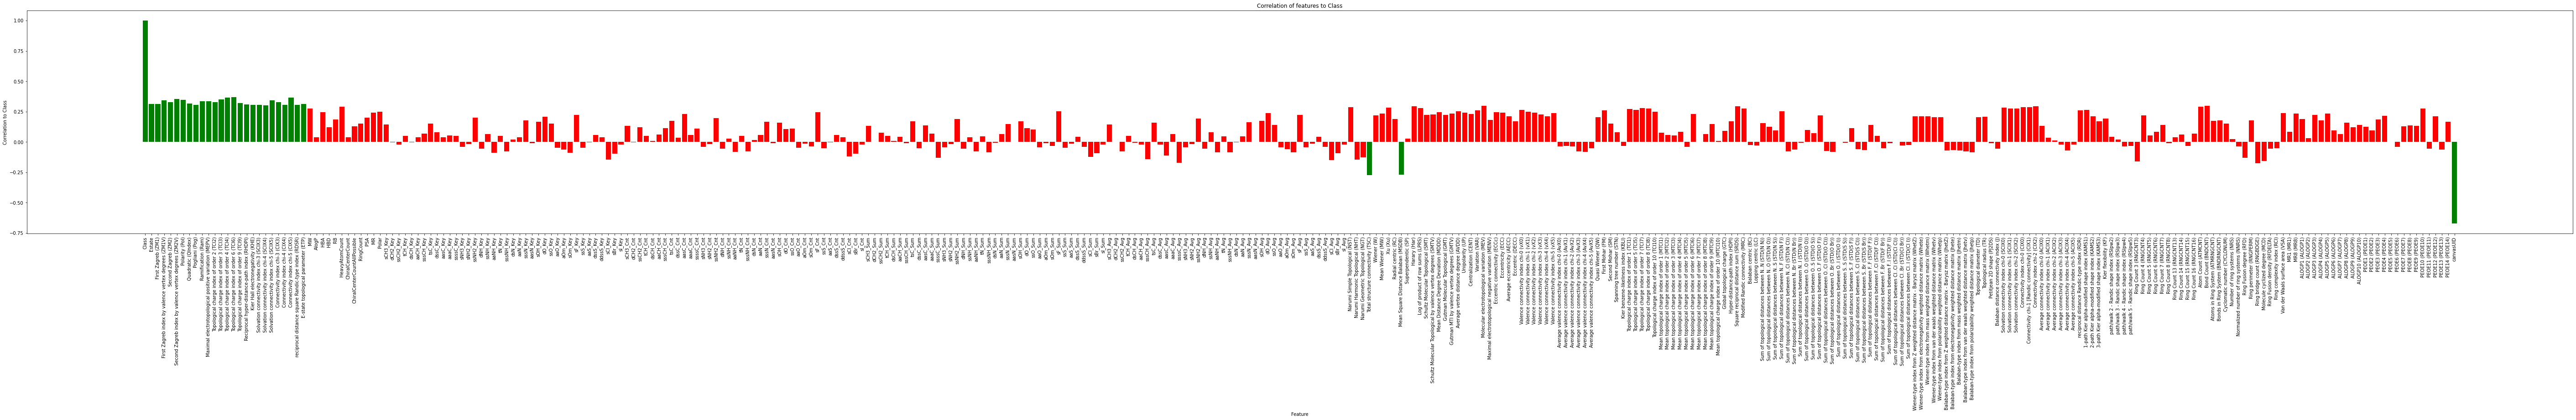

In [5]:
x = corr_mat.columns
y = corr_mat['Class']

mask1 = y >= 0.3
mask2 = y < 0.3
mask3 = y <= -0.2

plt.figure(figsize=(100,9))

plt.bar(x[mask1], y[mask1], color = 'Green')
plt.bar(x[mask2], y[mask2], color = 'Red')
plt.bar(x[mask3], y[mask3], color = 'Green')

plt.xticks(rotation=90)
plt.xlabel("Feature")
plt.ylabel("Correlation to Class")
plt.title("Correlation of features to Class")

plt.show()

In [6]:
pos_features = corr_mat['Class'].where(corr_mat['Class'] >= 0.3)
neg_features = corr_mat['Class'].where(corr_mat['Class'] <= -0.2)

pos_features.dropna(inplace=True)
neg_features.dropna(inplace=True)

features = pd.concat([pos_features, neg_features], axis=0)
features_list = features.index.tolist()
print(features_list, len(features_list))

['Class', 'Estate', 'First Zagreb (ZM1)', 'First Zagreb index by valence vertex degrees (ZM1V)', 'Second Zagreb (ZM2)', 'Second Zagreb index by valence vertex degrees (ZM2V)', 'Polarity (Pol)', 'Quadratic (QIndex)', 'Pogliani (Pog)', 'Ramification (Ram)', 'Maximal electrotopological positive variation (MEPV)', 'Topological charge index of order 2 (TCI2)', 'Topological charge index of order 3 (TCI3)', 'Topological charge index of order 4 (TCI4)', 'Topological charge index of order 6 (TCI6)', 'Topological charge index of order 9 (TCI9)', 'Reciprocal hyper-distance-path index (RHDPI)', 'Kier Hall electronegativity (KHE)', 'Solvation connectivity index chi-3 (SCIX3)', 'Solvation connectivity index chi-4 (SCIX4)', 'Solvation connectivity index chi-5 (SCIX5)', 'Connectivity index chi-3 (CIX3)', 'Connectivity index chi-4 (CIX4)', 'Connectivity index chi-5 (CIX5)', 'reciprocal distance square Randic-type index (RDSR)', 'E-state topological parameter (ETP)', 'Total structure connectivity (TSC)'

We have reduced our list of features to 28 (not counting 'Class'). Let's see how correlated these features are to each other

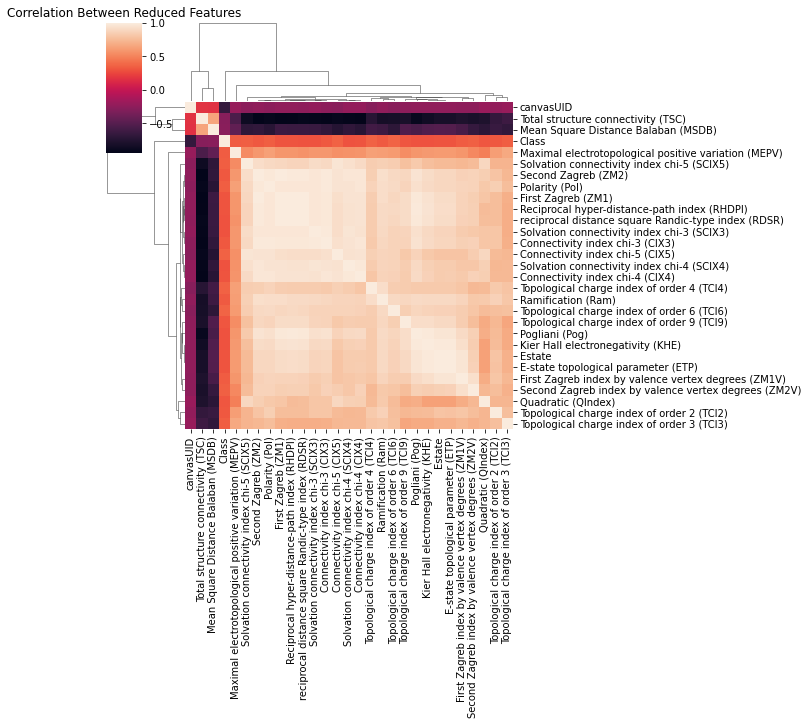

In [7]:
new_bace = bace[features_list].copy()

new_corr_mat = new_bace.corr()
new_corr_mat.shape

sns.clustermap(new_corr_mat)
plt.title("Correlation Between Reduced Features")
plt.show()

The features identified show a high degree of correlation to one another. It is probably worth combining like features to reduce the dimensionality of the matrix. It may also be that some features that are not as correlated to the label should be included to differentiate between the positive and negative cases. It is also interesting to observe that more typical molecular features such as MW, logP, HBDs etc. do not feature in this list. 

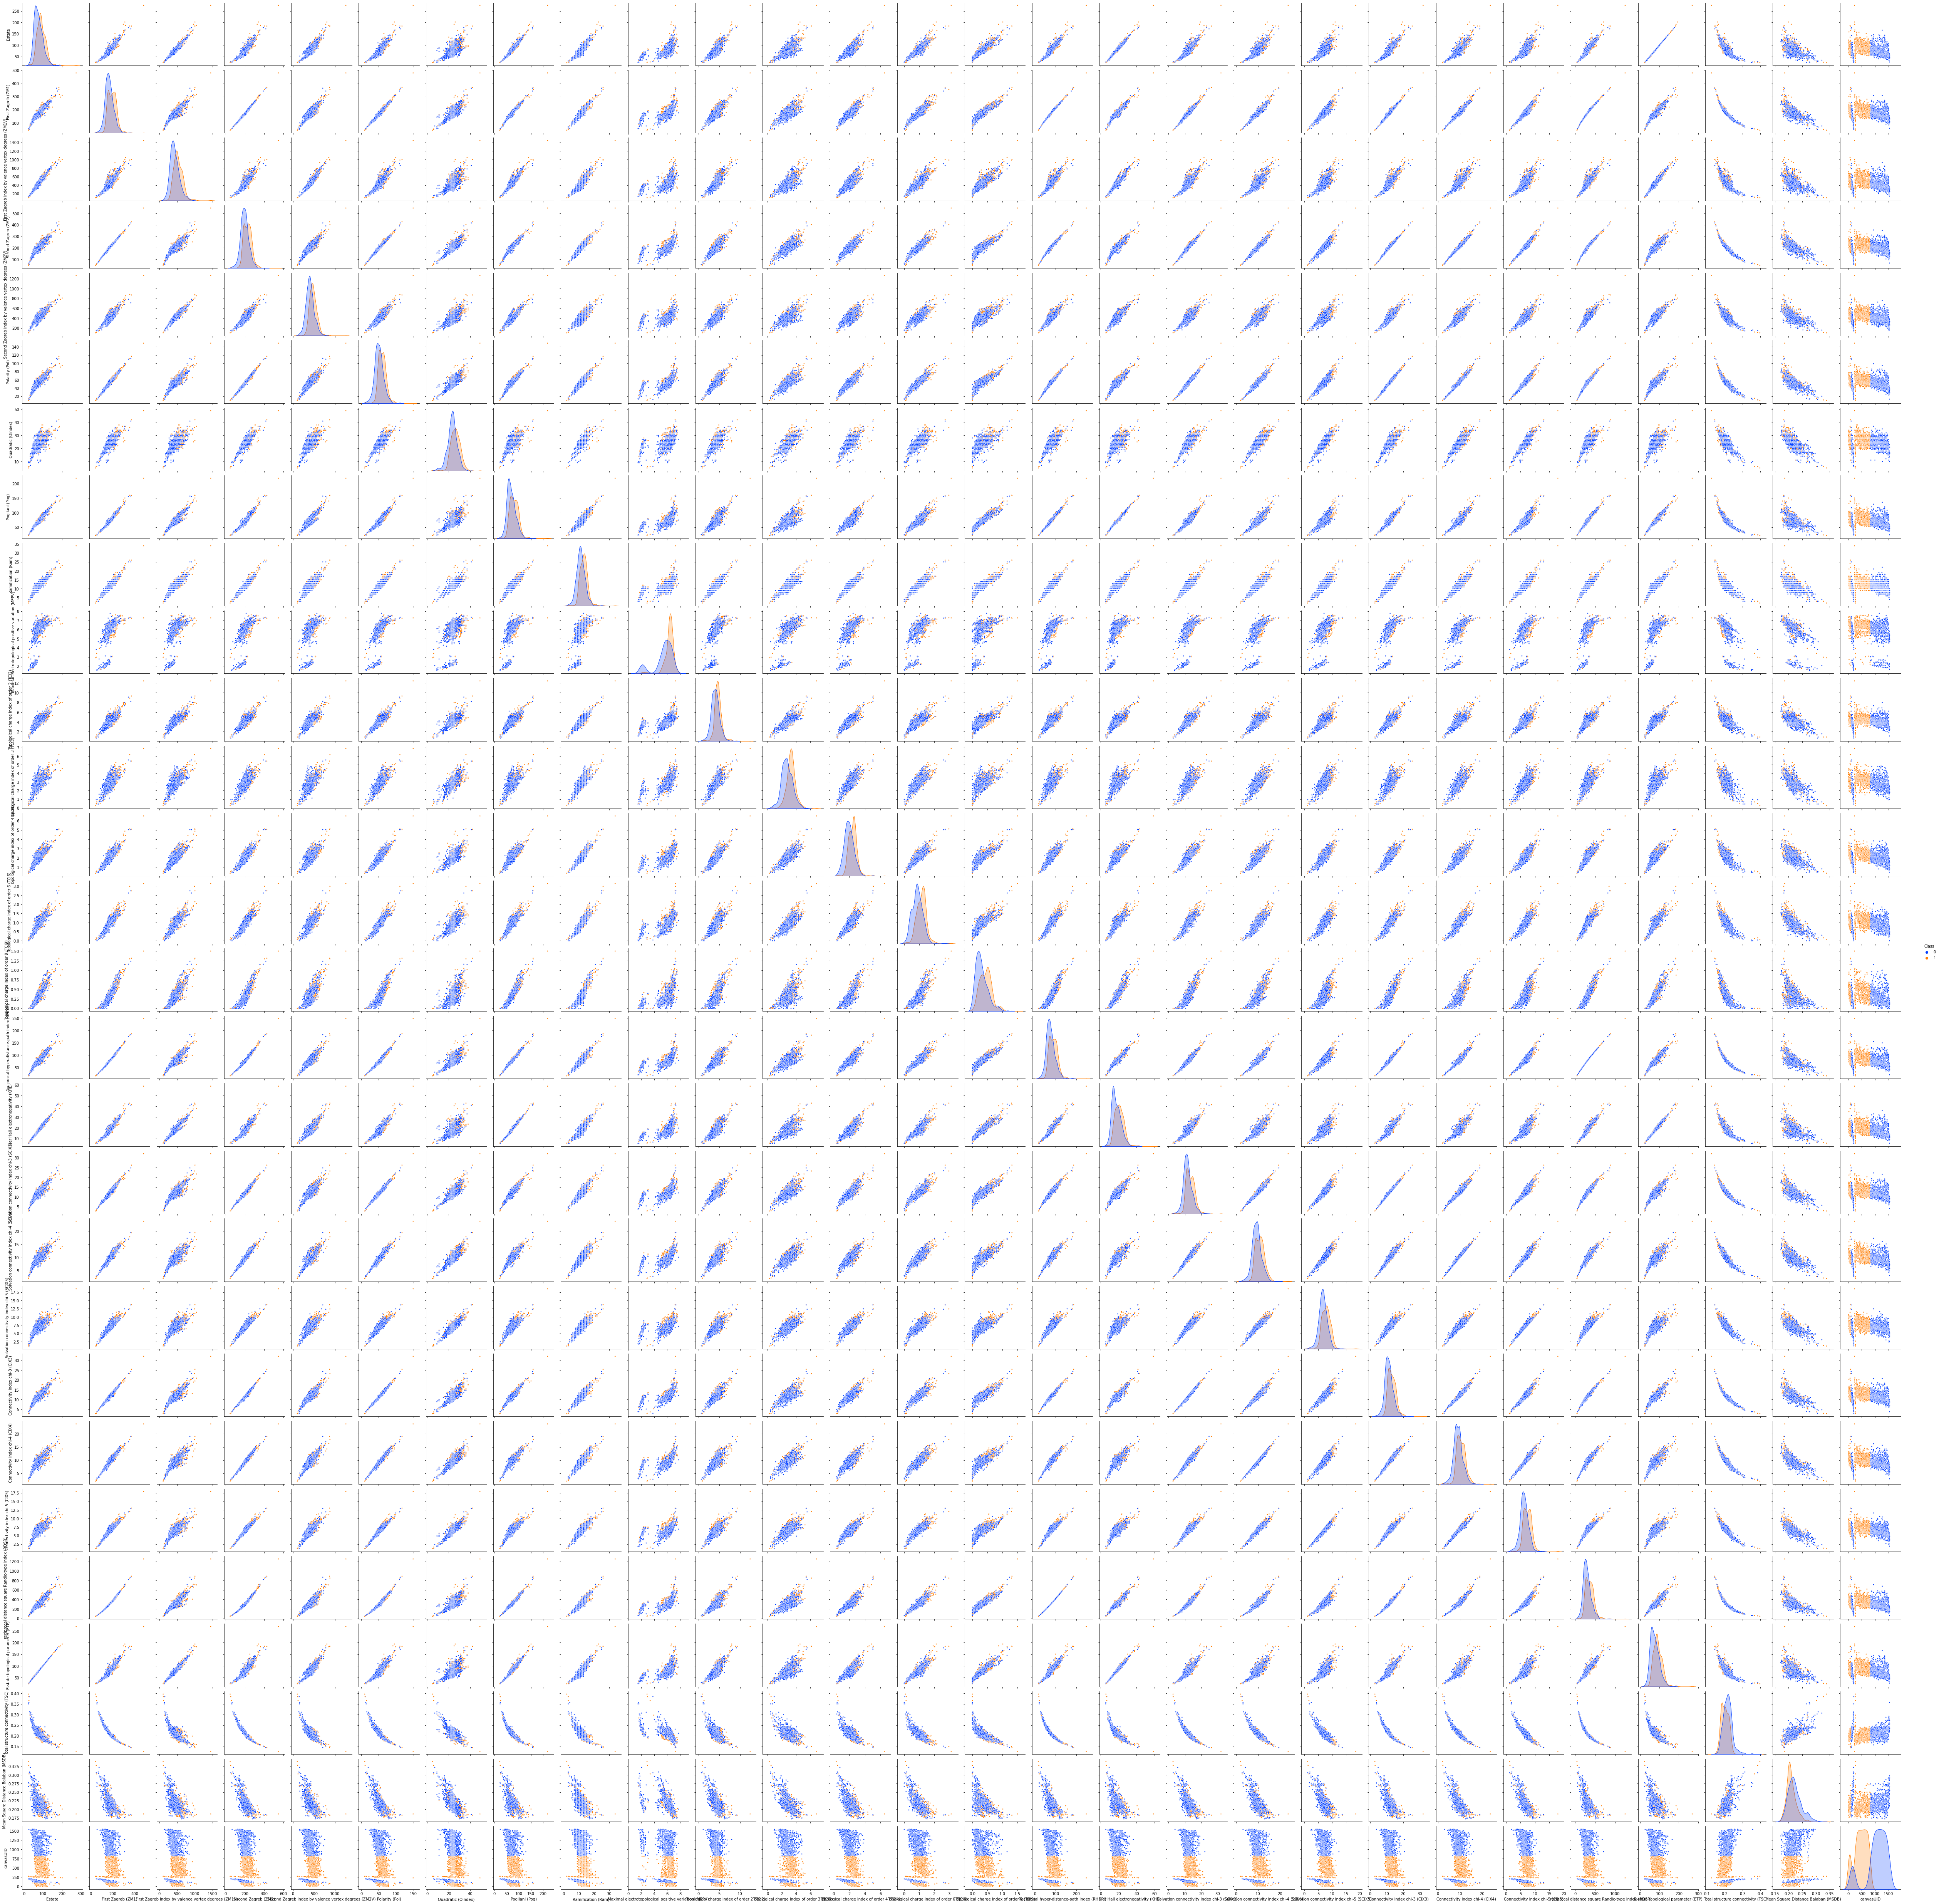

In [8]:
sns.pairplot(new_bace[features_list], diag_kind = "kde", markers = '.', hue = "Class", palette='bright')

plt.show()

canvasUID is likely a compound identifier number used in the Schrodinger analysis, so we will drop it. 

In [9]:
new_bace.drop('canvasUID', axis=1, inplace=True)
new_bace.head()

Class      Estate  First Zagreb (ZM1)  \
0      1   67.251999                 172   
1      1  115.417000                 240   
2      1   96.585999                 224   
3      1  112.751000                 210   
4      1  116.336000                 238   

   First Zagreb index by valence vertex degrees (ZM1V)  Second Zagreb (ZM2)  \
0                                          376.00000                    201   
1                                          631.00000                    278   
2                                          541.02368                    266   
3                                          629.02368                    241   
4                                          667.02368                    282   

   Second Zagreb index by valence vertex degrees (ZM2V)  Polarity (Pol)  \
0                                          401.00000                 52   
1                                          563.00000                 72   
2                                          482.92307                 74   
3                                          468.46155                 64   
4                                          552.92310                 78   

   Quadratic (QIndex)  Pogliani (Pog)  Ramification (Ram)  ...  \
0                  25       67.500000                  12  ...   
1                  29      104.000000                  16  ...   
2                  31       89.666664                  15  ...   
3                  28       90.666664                  16  ...   
4                  34       97.166664                  17  ...   

   Solvation connectivity index chi-3 (SCIX3)  \
0                                   11.706753   
1                                   15.748717   
2                                   16.955809   
3                                   14.221297   
4                                   17.494600   

   Solvation connectivity index chi-4 (SCIX4)  \
0                                    9.539850   
1                                   12.919102   
2                                   13.039178   
3                                   11.338008   
4                                   13.343642   

   Solvation connectivity index chi-5 (SCIX5)  \
0                                    6.388276   
1                                    9.410635   
2                                   10.296515   
3                                    8.611060   
4                                   10.649438   

   Connectivity index chi-3 (CIX3)  Connectivity index chi-4 (CIX4)  \
0                        11.706753                         9.539850   
1                        15.748717                        12.919102   
2                        15.838103                        12.267301   
3                        13.406523                        10.307978   
4                        16.376896                        12.571765   

   Connectivity index chi-5 (CIX5)  \
0                         6.388276   
1                         8.768809   
2                         9.262631   
3                         7.685516   
4                         9.615553   

   reciprocal distance square Randic-type index (RDSR)  \
0                                          291.77194     
1                                          501.91110     
2                                          438.77701     
3                                          388.44757     
4                                          467.85724     

   E-state topological parameter (ETP)  Total structure connectivity (TSC)  \
0                            67.250000                            0.209567   
1                           115.416660                            0.176732   
2                            96.138885                            0.181895   
3                           112.305560                            0.197866   
4                           115.888890                            0.179845   

   Mean Square Distance Balaban (MSDB)  
0              

Let's sum the like features into new combined features

In [10]:
types = {'zagreb': ['First Zagreb (ZM1)',
                    'First Zagreb index by valence vertex degrees (ZM1V)',
                    'Second Zagreb (ZM2)',
                    'Second Zagreb index by valence vertex degrees (ZM2V)'
                   ],
         'topo': ['Topological charge index of order 2 (TCI2)',
                  'Topological charge index of order 3 (TCI3)',
                  'Topological charge index of order 4 (TCI4)',
                  'Topological charge index of order 6 (TCI6)',
                  'Topological charge index of order 9 (TCI9)',
                 ],
         'connectivity': ['Solvation connectivity index chi-3 (SCIX3)',
                          'Solvation connectivity index chi-4 (SCIX4)',
                          'Solvation connectivity index chi-5 (SCIX5)',
                          'Connectivity index chi-3 (CIX3)',
                          'Connectivity index chi-4 (CIX4)',
                          'Connectivity index chi-5 (CIX5)',
                          'Total structure connectivity (TSC)',
                         ]
         }

for i in types:
    col_name = f'{i}_combined'
    for j in types[i]:
        if col_name in new_bace.columns:
            new_bace[col_name] += new_bace[j]
        else:
            new_bace[col_name] = new_bace[j]

new_bace.head()

Class      Estate  First Zagreb (ZM1)  \
0      1   67.251999                 172   
1      1  115.417000                 240   
2      1   96.585999                 224   
3      1  112.751000                 210   
4      1  116.336000                 238   

   First Zagreb index by valence vertex degrees (ZM1V)  Second Zagreb (ZM2)  \
0                                          376.00000                    201   
1                                          631.00000                    278   
2                                          541.02368                    266   
3                                          629.02368                    241   
4                                          667.02368                    282   

   Second Zagreb index by valence vertex degrees (ZM2V)  Polarity (Pol)  \
0                                          401.00000                 52   
1                                          563.00000                 72   
2                                          482.92307                 74   
3                                          468.46155                 64   
4                                          552.92310                 78   

   Quadratic (QIndex)  Pogliani (Pog)  Ramification (Ram)  ...  \
0                  25       67.500000                  12  ...   
1                  29      104.000000                  16  ...   
2                  31       89.666664                  15  ...   
3                  28       90.666664                  16  ...   
4                  34       97.166664                  17  ...   

   Connectivity index chi-3 (CIX3)  Connectivity index chi-4 (CIX4)  \
0                        11.706753                         9.539850   
1                        15.748717                        12.919102   
2                        15.838103                        12.267301   
3                        13.406523                        10.307978   
4                        16.376896                        12.571765   

   Connectivity index chi-5 (CIX5)  \
0                         6.388276   
1                         8.768809   
2                         9.262631   
3                         7.685516   
4                         9.615553   

   reciprocal distance square Randic-type index (RDSR)  \
0                                          291.77194     
1                                          501.91110     
2                                          438.77701     
3                                          388.44757     
4                                          467.85724     

   E-state topological parameter (ETP)  Total structure connectivity (TSC)  \
0                            67.250000                            0.209567   
1                           115.416660                            0.176732   
2                            96.138885                            0.181895   
3                           112.305560                            0.197866   
4                           115.888890                            0.179845   

   Mean Square Distance Balaban (MSDB)  zagreb_combined  topo_combined  \
0                             0.240719       1150.00000      10.265109   
1                             0.181466       1712.00000      14.723245   
2                             0.203680       1513.94675      13.647994   
3                             0.219697       1548.48523      14.631270   
4                             0.202943       1739.94678      15.331293   

   connectivity_combined  
0              55.479325  
1              75.691815  
2              77.841432  
3              65.768248  
4              80.231739  

[5 rows x 31 columns]

Now we should drop the old columns

In [12]:
for i in types:
    for j in types[i]:
        if j in new_bace.columns:
            new_bace.drop(j, axis=1, inplace=True)
            
new_bace.head()

Class      Estate  Polarity (Pol)  Quadratic (QIndex)  Pogliani (Pog)  \
0      1   67.251999              52                  25       67.500000   
1      1  115.417000              72                  29      104.000000   
2      1   96.585999              74                  31       89.666664   
3      1  112.751000              64                  28       90.666664   
4      1  116.336000              78                  34       97.166664   

   Ramification (Ram)  Maximal electrotopological positive variation (MEPV)  \
0                  12                                           5.864976      
1                  16                                           7.325500      
2                  15                                           6.793797      
3                  16                                           6.646171      
4                  17                                           6.762085      

   Reciprocal hyper-distance-path index (RHDPI)  \
0                                     74.889656   
1                                    115.870310   
2                                    104.114360   
3                                     95.274330   
4                                    109.995320   

   Kier Hall electronegativity (KHE)  \
0                          16.250000   
1                          27.000000   
2                          22.277779   
3                          24.777779   
4                          25.027779   

   reciprocal distance square Randic-type index (RDSR)  \
0                                          291.77194     
1                                          501.91110     
2                                          438.77701     
3                                          388.44757     
4                                          467.85724     

   E-state topological parameter (ETP)  Mean Square Distance Balaban (MSDB)  \
0                            67.250000                             0.240719   
1                           115.416660                             0.181466   
2                            96.138885                             0.203680   
3                           112.305560                             0.219697   
4                           115.888890                             0.202943   

   zagreb_combined  topo_combined  connectivity_combined  
0       1150.00000      10.265109              55.479325  
1       1712.00000      14.723245              75.691815  
2       1513.94675      13.647994              77.841432  
3       1548.48523      14.631270              65.768248  
4       1739.94678      15.331293              80.231739

In [13]:
new_bace.shape

(1513, 15)

Awesome - we are down to only 14 features (again, not counting 'class'). Let's normalise our data and check for any outliers.

In [14]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

min_max = scaler.fit_transform(new_bace)

new_bace_norm = pd.DataFrame(min_max, columns=new_bace.columns)

new_bace_norm.head()

Class    Estate  Polarity (Pol)  Quadratic (QIndex)  Pogliani (Pog)  \
0    1.0  0.174508        0.302158            0.454545        0.233503   
1    1.0  0.365891        0.446043            0.545455        0.418782   
2    1.0  0.291066        0.460432            0.590909        0.346024   
3    1.0  0.355297        0.388489            0.522727        0.351100   
4    1.0  0.369542        0.489209            0.659091        0.384095   

   Ramification (Ram)  Maximal electrotopological positive variation (MEPV)  \
0             0.31250                                           0.696658      
1             0.43750                                           0.930443      
2             0.40625                                           0.845334      
3             0.43750                                           0.821703      
4             0.46875                                           0.840258      

   Reciprocal hyper-distance-path index (RHDPI)  \
0                                      0.252091   
1                                      0.429520   
2                                      0.378622   
3                                      0.340348   
4                                      0.404084   

   Kier Hall electronegativity (KHE)  \
0                           0.201878   
1                           0.403756   
2                           0.315076   
3                           0.362024   
4                           0.366719   

   reciprocal distance square Randic-type index (RDSR)  \
0                                           0.203785     
1                                           0.378031     
2                                           0.325681     
3                                           0.283948     
4                                           0.349794     

   E-state topological parameter (ETP)  Mean Square Distance Balaban (MSDB)  \
0                             0.178765                             0.411900   
1                             0.374830                             0.056775   
2                             0.296359                             0.189911   
3                             0.362166                             0.285909   
4                             0.376753                             0.185498   

   zagreb_combined  topo_combined  connectivity_combined  
0         0.247818       0.300840               0.316908  
1         0.411286       0.454943               0.465831  
2         0.353679       0.417775               0.481669  
3         0.363725       0.451764               0.392715  
4         0.419414       0.475961               0.499280

In [15]:
def plot_cont_features(dataset, features, label):
    for i in features:
        pos = list(dataset[dataset[label] == 1][i])
        neg = list(dataset[dataset[label] == 0][i])
        xmin = min(min(pos), min(neg))
        xmax = max((max(pos), max(neg), (max(pos)+0.1)))
        width = (xmax - xmin) / 40
        sns.histplot(pos, color='r', kde=False, bins=np.arange(xmin, xmax, width))
        sns.histplot(neg, color='b', kde=False, bins=np.arange(xmin, xmax, width))
        plt.legend(['positive', 'negative'])
        plt.title('Overlaid histogram for {}'.format(i))
        plt.show()

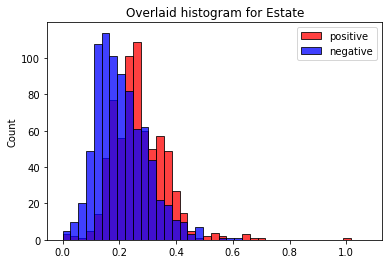

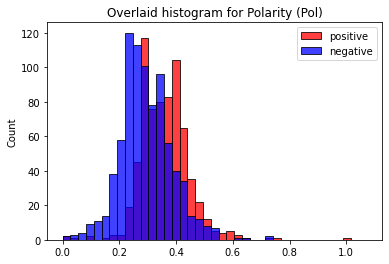

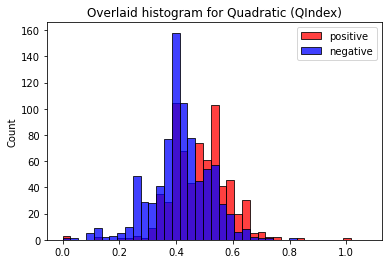

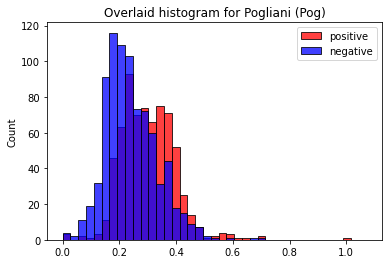

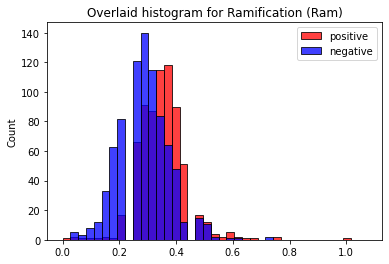

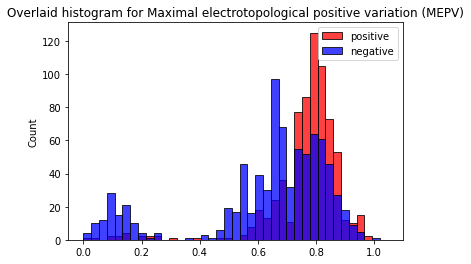

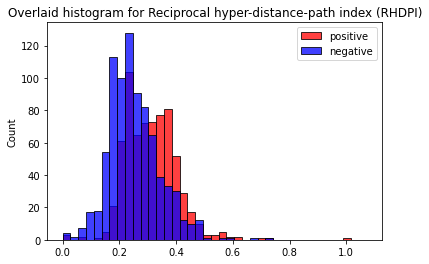

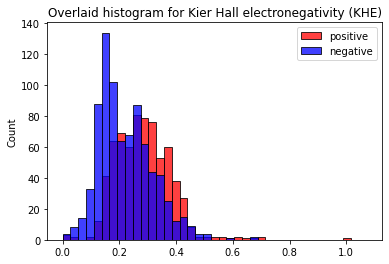

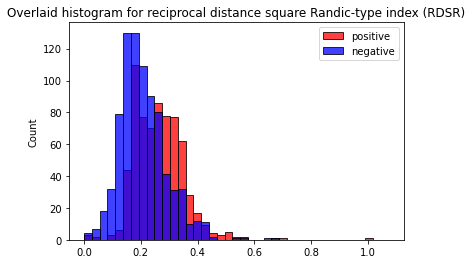

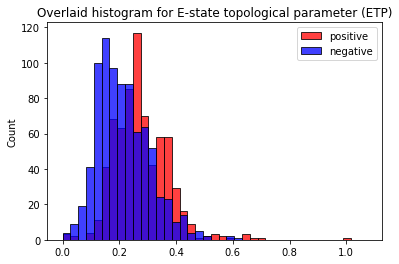

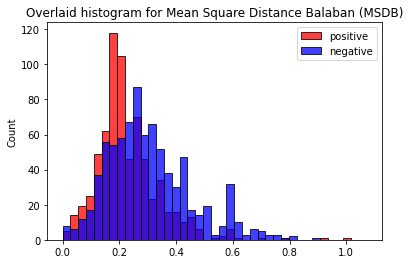

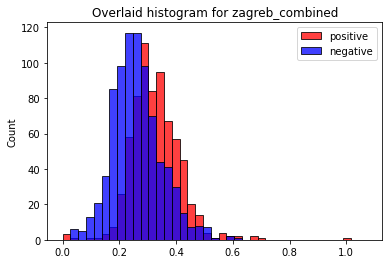

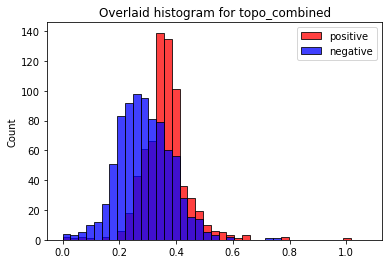

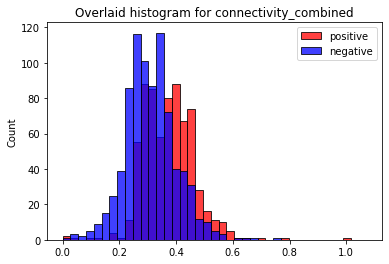

In [16]:
feats_df = new_bace_norm.drop('Class', axis=1)

features = feats_df.columns.tolist()

plot_cont_features(new_bace_norm, features, 'Class')

In [17]:
def detect_outliers(dataset, feature):
    outliers = []
    data = dataset[feature]
    mean = np.mean(data)
    std =np.std(data)
    
    
    for y in data:
        z_score= (y - mean)/std 
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data.quantile(.95),
                                                             len([i for i in data
                                                                  if i > data.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3*(std), len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data.quantile(.99),
                                                           len([i for i in data
                                                                if i > data.quantile(.99)])))

In [18]:
for i in features:
    detect_outliers(new_bace_norm, i)


Outlier caps for Estate:
  --95p: 0.4 / 76 values exceed that
  --3sd: 0.5 / 15 values exceed that
  --99p: 0.5 / 16 values exceed that

Outlier caps for Polarity (Pol):
  --95p: 0.5 / 73 values exceed that
  --3sd: 0.6 / 18 values exceed that
  --99p: 0.6 / 16 values exceed that

Outlier caps for Quadratic (QIndex):
  --95p: 0.6 / 60 values exceed that
  --3sd: 0.8 / 17 values exceed that
  --99p: 0.7 / 15 values exceed that

Outlier caps for Pogliani (Pog):
  --95p: 0.4 / 76 values exceed that
  --3sd: 0.6 / 13 values exceed that
  --99p: 0.5 / 16 values exceed that

Outlier caps for Ramification (Ram):
  --95p: 0.5 / 47 values exceed that
  --3sd: 0.6 / 24 values exceed that
  --99p: 0.6 / 16 values exceed that

Outlier caps for Maximal electrotopological positive variation (MEPV):
  --95p: 0.9 / 76 values exceed that
  --3sd: 1.3 / 43 values exceed that
  --99p: 0.9 / 16 values exceed that

Outlier caps for Reciprocal hyper-distance-path index (RHDPI):
  --95p: 0.4 / 76 values exc

In [19]:
# Clip features
def clip_features(dataset, features, cutoff): 
    for i in features:
        dataset[i].clip(upper=dataset[i].quantile(cutoff), inplace=True)

In [20]:
clip_features(new_bace_norm, features, 0.99)

new_bace_norm.head()

Class    Estate  Polarity (Pol)  Quadratic (QIndex)  Pogliani (Pog)  \
0    1.0  0.174508        0.302158            0.454545        0.233503   
1    1.0  0.365891        0.446043            0.545455        0.418782   
2    1.0  0.291066        0.460432            0.590909        0.346024   
3    1.0  0.355297        0.388489            0.522727        0.351100   
4    1.0  0.369542        0.489209            0.659091        0.384095   

   Ramification (Ram)  Maximal electrotopological positive variation (MEPV)  \
0             0.31250                                           0.696658      
1             0.43750                                           0.930443      
2             0.40625                                           0.845334      
3             0.43750                                           0.821703      
4             0.46875                                           0.840258      

   Reciprocal hyper-distance-path index (RHDPI)  \
0                                      0.252091   
1                                      0.429520   
2                                      0.378622   
3                                      0.340348   
4                                      0.404084   

   Kier Hall electronegativity (KHE)  \
0                           0.201878   
1                           0.403756   
2                           0.315076   
3                           0.362024   
4                           0.366719   

   reciprocal distance square Randic-type index (RDSR)  \
0                                           0.203785     
1                                           0.378031     
2                                           0.325681     
3                                           0.283948     
4                                           0.349794     

   E-state topological parameter (ETP)  Mean Square Distance Balaban (MSDB)  \
0                             0.178765                             0.411900   
1                             0.374830                             0.056775   
2                             0.296359                             0.189911   
3                             0.362166                             0.285909   
4                             0.376753                             0.185498   

   zagreb_combined  topo_combined  connectivity_combined  
0         0.247818       0.300840               0.316908  
1         0.411286       0.454943               0.465831  
2         0.353679       0.417775               0.481669  
3         0.363725       0.451764               0.392715  
4         0.419414       0.475961               0.499280

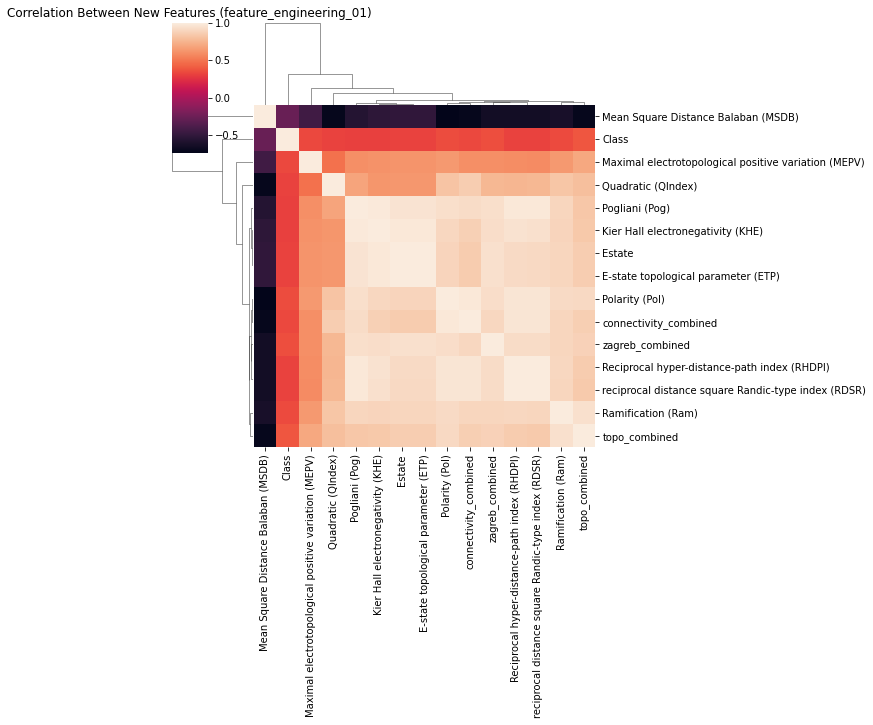

In [25]:
new_corrs = new_bace_norm.corr()

sns.clustermap(new_corrs)
plt.title("Correlation Between New Features (feature_engineering_01)")
plt.show()

Let's see what kind of performance we get from these features by performing a cross-validation training on a number of different machine learning methods

In [21]:
from sklearn.model_selection import train_test_split

features = new_bace_norm.drop('Class', axis=1)
labels = pd.DataFrame(new_bace_norm, columns=['Class'])

x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=42, test_size=0.4) # training set
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, random_state=42, test_size=0.5) # splits remaining into val and test

In [23]:
# export datasets
new_bace_norm.to_csv('./feature_engineering_01.csv', index=False)
x_train.to_csv('./x_train_features.csv', index=False)
x_val.to_csv('./x_val_features.csv', index=False)    
x_test.to_csv('./x_test_features.csv', index=False)

y_train.to_csv('./y_train_labels.csv', index=False)
y_val.to_csv('./y_val_labels.csv', index=False)
y_test.to_csv('./y_test_labels.csv', index=False)